# Ensemble GradCAM Visualization for Chest X-ray Classification

This notebook implements GradCAM visualization for an ensemble of deep learning models performing multi-label chest X-ray classification. The visualization shows class activation maps for each model in the ensemble along with per-class prediction scores.

## Import Required Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.models import densenet121, DenseNet121_Weights, efficientnet_b2, EfficientNet_B2_Weights, efficientnet_b3, EfficientNet_B3_Weights
import glob
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## Configuration and Setup

In [2]:
CONFIG = {
    'batch_size': 8,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_dir': './processed_images/data',
    'models_dir': './Final Models',
    'seed': 42
}

disease_list = [
    'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
    'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass',
    'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'
]

transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print(f'Device: {CONFIG["device"]}')
print(f'Number of disease classes: {len(disease_list)}')

Device: cuda
Number of disease classes: 14


## Dataset Loading and Preprocessing

In [3]:
def get_label_vector(labels_str):
    labels = labels_str.split('|')
    if labels == ['No Finding']:
        return [0] * len(disease_list)
    return [1 if d in labels else 0 for d in disease_list]

class CheXNetDataset(Dataset):
    def __init__(self, df, image_to_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_to_folder = image_to_folder
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['Image Index']
        folder = self.image_to_folder[img]
        path = os.path.join(folder, img)
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        labels = torch.tensor(get_label_vector(row['Finding Labels']), dtype=torch.float)
        return image, labels, path

data_path = CONFIG['data_dir']
csv_file = os.path.join(data_path, 'Data_Entry_2017.csv')
df = pd.read_csv(csv_file)

image_folders = [os.path.join(data_path, f'images_{str(i).zfill(3)}', 'images') for i in range(1, 13)]
image_to_folder = {}
for folder in image_folders:
    if os.path.exists(folder):
        for f in os.listdir(folder):
            if f.endswith('.png'):
                image_to_folder[f] = folder

df = df[df['Image Index'].isin(image_to_folder.keys())].reset_index(drop=True)

unique_patients = df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(unique_patients, test_size=0.02, random_state=CONFIG['seed'])
test_df = df[df['Patient ID'].isin(test_patients)]

testloader = DataLoader(
    CheXNetDataset(test_df, image_to_folder, transform=transform_test), 
    batch_size=32, 
    shuffle=False, 
    num_workers=0
)

print(f'Test dataset size: {len(test_df)}')

Test dataset size: 2299


## Model Architecture Definitions

In [4]:
def create_densenet_model():
    model = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
    model.classifier = nn.Linear(model.classifier.in_features, 14)
    return model

def create_efficientnet_b2_model():
    model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

def create_efficientnet_b3_model():
    model = efficientnet_b3(weights=EfficientNet_B3_Weights.IMAGENET1K_V1)
    num_features = model.classifier[1].in_features
    model.classifier = nn.Linear(num_features, 14)
    return model

# Attention mechanism
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1
        
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.ca(x)
        x = x * self.sa(x)
        return x

class DenseNetCBAM(nn.Module):
    def __init__(self, num_classes=14):
        super(DenseNetCBAM, self).__init__()
        self.densenet = densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        num_features = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Identity()
        self.attention = CBAM(num_features)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(num_features, num_classes)
        
    def forward(self, x):
        features = self.densenet.features(x)
        attended_features = self.attention(features)
        pooled = self.global_pool(attended_features)
        pooled = pooled.view(pooled.size(0), -1)
        output = self.dropout(pooled)
        output = self.classifier(output)
        
        return output

def create_densenet_attention_model():
    return DenseNetCBAM()

print("Model architectures defined")

Model architectures defined


## Model Loading and Ensemble Setup

In [5]:
def detect_model_architecture(model_path):
    try:
        state_dict = torch.load(model_path, map_location='cpu')
        
        attention_keys = ['attention.ca.fc1.weight', 'attention.ca.fc2.weight', 'attention.sa.conv1.weight']
        densenet_prefixed_keys = ['densenet.features.conv0.weight', 'densenet.features.norm0.weight']
        if all(key in state_dict for key in attention_keys) and any(key in state_dict for key in densenet_prefixed_keys):
            return 'densenet_attention'
        
        densenet_keys = ['features.conv0.weight', 'features.denseblock1.denselayer1.norm1.weight']
        if all(key in state_dict for key in densenet_keys):
            return 'densenet'
        
        efficientnet_keys = ['features.0.0.weight', 'features.1.0.block.0.0.weight']
        if any(key in state_dict for key in efficientnet_keys):
            first_conv_key = 'features.0.0.weight'
            if first_conv_key in state_dict:
                out_channels = state_dict[first_conv_key].shape[0]
                if out_channels == 32:
                    return 'efficientnet_b2'
                elif out_channels == 40:
                    return 'efficientnet_b3'
        
        return 'unknown'
    except Exception:
        return 'unknown'

model_paths = glob.glob(os.path.join(CONFIG['models_dir'], '*.pth'))
models = []
model_names = []

for path in model_paths:
    try:
        arch = detect_model_architecture(path)
        if arch == 'densenet':
            model = create_densenet_model()
            name = os.path.splitext(os.path.basename(path))[0]  # Use actual .pth filename
        elif arch == 'densenet_attention':
            model = create_densenet_attention_model()
            name = os.path.splitext(os.path.basename(path))[0]  # Use actual .pth filename
        elif arch == 'efficientnet_b2':
            model = create_efficientnet_b2_model()
            name = os.path.splitext(os.path.basename(path))[0]  # Use actual .pth filename
        elif arch == 'efficientnet_b3':
            model = create_efficientnet_b3_model()
            name = os.path.splitext(os.path.basename(path))[0]  # Use actual .pth filename
        else:
            continue
        
        model.load_state_dict(torch.load(path, map_location=CONFIG['device']))
        model.to(CONFIG['device'])
        model.eval()
        models.append(model)
        model_names.append(name)
        print(f'Loaded: {name}')
    except Exception as e:
        print(f'Failed to load {os.path.basename(path)}: {e}')

print(f'Total models loaded: {len(models)}')

Loaded: seed 22 - densnet 121 - focal loss
Loaded: seed 22 - densnet 121 - ZLPR loss
Loaded: seed 22 - densnet 121 - ZLPR loss
Loaded: seed 32 - densenet 121 - ZLPR loss
Loaded: seed 32 - densenet 121 - ZLPR loss
Loaded: seed 32- densnet121 - focal loss
Loaded: seed 32- densnet121 - focal loss
Loaded: seed 42 - densnet 121 - focal loss
Loaded: seed 42 - densnet 121 - focal loss
Loaded: seed 42 - densnet 121 - ZLPR loss
Loaded: seed 42 - densnet 121 - ZLPR loss
Loaded: seed 42 - densnet121- Attention - focal loss
Loaded: seed 42 - densnet121- Attention - focal loss
Loaded: seed 42 - efficienet b3 - focal loss
Loaded: seed 42 - efficienet b3 - focal loss
Loaded: seed 42 - efficinet b2 - focal loss
Total models loaded: 9
Loaded: seed 42 - efficinet b2 - focal loss
Total models loaded: 9


## Ensemble Model Evaluation

In [6]:
from sklearn.metrics import roc_auc_score, f1_score, precision_recall_curve
from tqdm.auto import tqdm

def get_test_predictions(models, dataloader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for x, y, _ in tqdm(dataloader, desc="Evaluating ensemble"):
            x = x.to(device)
            batch_predictions = []
            
            for model in models:
                output = model(x)
                batch_predictions.append(torch.sigmoid(output).cpu())
            
            all_predictions.append(torch.stack(batch_predictions))
            all_labels.append(y)
    
    predictions = torch.cat(all_predictions, dim=1)
    labels = torch.cat(all_labels, dim=0)
    return predictions.numpy(), labels.numpy()

def evaluate_ensemble(labels, predictions):
    ensemble_pred = np.mean(predictions, axis=0)
    
    thresholds = []
    for i in range(predictions.shape[2]):
        precision, recall, thresh = precision_recall_curve(labels[:, i], ensemble_pred[:, i])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_threshold = thresh[np.argmax(f1_scores)] if len(thresh) > 0 else 0.5
        thresholds.append(best_threshold)
    
    binary_predictions = np.zeros_like(ensemble_pred)
    for i in range(ensemble_pred.shape[1]):
        binary_predictions[:, i] = (ensemble_pred[:, i] > thresholds[i]).astype(int)
    
    aucs = [roc_auc_score(labels[:, i], ensemble_pred[:, i]) for i in range(labels.shape[1])]
    f1s = [f1_score(labels[:, i], binary_predictions[:, i]) for i in range(labels.shape[1])]
    
    return {
        'mean_auc': np.mean(aucs),
        'mean_f1': np.mean(f1s),
        'per_class_auc': aucs,
        'per_class_f1': f1s,
        'thresholds': thresholds
    }

print("Evaluation functions ready")

Evaluation functions ready


In [7]:
print("Evaluating ensemble performance on test dataset...")
test_predictions, test_labels = get_test_predictions(models, testloader, CONFIG['device'])

results = evaluate_ensemble(test_labels, test_predictions)

print(f"\n=== Ensemble Performance Results ===")
print(f"Mean AUC: {results['mean_auc']:.4f}")
print(f"Mean F1 Score: {results['mean_f1']:.4f}")

print(f"\n=== Per-Class Performance ===")
for i, disease in enumerate(disease_list):
    print(f"{disease:<20}: AUC={results['per_class_auc'][i]:.4f}, F1={results['per_class_f1'][i]:.4f}")

print(f"\nTotal test samples: {len(test_labels)}")
print(f"Number of models in ensemble: {len(models)}")
print("-" * 60)

Evaluating ensemble performance on test dataset...


Evaluating ensemble: 100%|██████████| 72/72 [01:39<00:00,  1.38s/it]


=== Ensemble Performance Results ===
Mean AUC: 0.8559
Mean F1 Score: 0.3856

=== Per-Class Performance ===
Atelectasis         : AUC=0.8215, F1=0.4084
Cardiomegaly        : AUC=0.9405, F1=0.5035
Consolidation       : AUC=0.7834, F1=0.2402
Edema               : AUC=0.8976, F1=0.2635
Effusion            : AUC=0.9059, F1=0.6245
Emphysema           : AUC=0.9705, F1=0.5563
Fibrosis            : AUC=0.8448, F1=0.1531
Hernia              : AUC=0.9937, F1=0.7500
Infiltration        : AUC=0.7078, F1=0.4140
Mass                : AUC=0.9126, F1=0.4917
Nodule              : AUC=0.7862, F1=0.3258
Pleural_Thickening  : AUC=0.8073, F1=0.2448
Pneumonia           : AUC=0.7193, F1=0.0683
Pneumothorax        : AUC=0.8908, F1=0.3537

Total test samples: 2299
Number of models in ensemble: 9
------------------------------------------------------------


## GradCAM Implementation

In [8]:
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer_name = target_layer_name
        self.feature_maps = None
        self.gradients = None
        
        self.hook_layers()
    
    def hook_layers(self):
        def forward_hook(module, input, output):
            self.feature_maps = output
        
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_tensor, class_idx=None):
        self.model.eval()
        
        input_tensor = input_tensor.unsqueeze(0) if input_tensor.dim() == 3 else input_tensor
        input_tensor.requires_grad_()
        
        outputs = self.model(input_tensor)
        
        if class_idx is None:
            class_idx = outputs.argmax(dim=1).item()
        
        target = outputs[0, class_idx]
        target.backward()
        
        gradients = self.gradients[0].cpu().data.numpy()
        feature_maps = self.feature_maps[0].cpu().data.numpy()
        
        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(feature_maps.shape[1:], dtype=np.float32)
        
        for i, w in enumerate(weights):
            cam += w * feature_maps[i, :, :]
        
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam) if np.max(cam) > 0 else cam
        
        return cam

def get_target_layer_name(model, model_name):
    # First check the actual model structure to determine the correct layer
    if hasattr(model, 'densenet'):  # DenseNet with attention
        return 'densenet.features.norm5'
    elif hasattr(model, 'features') and hasattr(model.features, 'norm5'):  # Regular DenseNet
        return 'features.norm5'
    elif hasattr(model, 'features') and hasattr(model.features, '8'):  # EfficientNet
        return 'features.8.0'
    else:
        # Fallback: try to find the last normalization or activation layer
        module_names = list(dict(model.named_modules()).keys())
        
        # Look for common last layer patterns
        for pattern in ['features.norm5', 'features.8.0', 'features.7', 'classifier']:
            if pattern in module_names:
                return pattern
        
        # If nothing found, use the last convolutional feature layer
        feature_layers = [name for name in module_names if 'features' in name and ('conv' in name or 'norm' in name)]
        if feature_layers:
            return feature_layers[-1]
        
        # Final fallback
        raise ValueError(f"Could not determine target layer for model: {model_name}. Available layers: {module_names[:10]}...")

print("GradCAM implementation ready")

GradCAM implementation ready


## Visualization Functions

In [9]:
def denormalize_image(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = tensor.cpu().numpy().transpose(1, 2, 0)
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

def overlay_heatmap(image, heatmap, alpha=0.4):
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    heatmap_colored = heatmap_colored / 255.0
    
    overlay = alpha * heatmap_colored + (1 - alpha) * image
    return overlay

def get_ensemble_predictions(models, input_tensor, device):
    predictions = []
    with torch.no_grad():
        input_batch = input_tensor.unsqueeze(0).to(device)
        for model in models:
            output = model(input_batch)
            predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    
    ensemble_pred = np.mean(predictions, axis=0)
    return predictions, ensemble_pred

def visualize_high_confidence_gradcam(image_tensor, image_path, models, model_names, disease_list, device):
    original_image = denormalize_image(image_tensor)
    individual_preds, ensemble_pred = get_ensemble_predictions(models, image_tensor, device)
    
    # Find diseases with ensemble prediction > 0.5
    high_conf_indices = [i for i in range(len(disease_list)) if ensemble_pred[i] > 0.5]
    
    if not high_conf_indices:
        print("No diseases with ensemble prediction > 0.5 found for this image.")
        return individual_preds, ensemble_pred
    
    # Original Image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Generate GradCAM for each high-confidence disease class
    for disease_idx in high_conf_indices:
        disease_name = disease_list[disease_idx]
        disease_prob = ensemble_pred[disease_idx]
        
        print(f"\nGenerating GradCAM for {disease_name} (Ensemble prob: {disease_prob:.3f})")
        
        # Create subplot for all models for this disease
        num_models = len(models)
        fig, axes = plt.subplots(1, num_models, figsize=(4*num_models, 4))
        if num_models == 1:
            axes = [axes]
        
        # Generate individual model heatmaps and collect them for ensemble
        all_cams = []
        for i, (model, model_name) in enumerate(zip(models, model_names)):
            target_layer = get_target_layer_name(model, model_name)
            gradcam = GradCAM(model, target_layer)
            
            # Generate GradCAM for the specific disease class
            cam = gradcam.generate_cam(image_tensor.to(device), disease_idx)
            all_cams.append(cam)
            overlay = overlay_heatmap(original_image, cam)
            
            axes[i].imshow(overlay)
            model_pred = individual_preds[i][disease_idx]
            axes[i].set_title(f'{model_name}\n{disease_name}\nScore: {model_pred:.3f}', fontsize=10)
            axes[i].axis('off')
        
        plt.suptitle(f'Individual Model GradCAM for {disease_name} (Ensemble: {disease_prob:.3f})', fontsize=14, y=1.02)
        plt.tight_layout()
        plt.show()
        
        # Generate Combined Ensemble Heatmap
        ensemble_cam = np.mean(all_cams, axis=0)
        ensemble_overlay = overlay_heatmap(original_image, ensemble_cam)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(ensemble_overlay)
        plt.title(f'Ensemble GradCAM for {disease_name}\nEnsemble Score: {disease_prob:.3f}', fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Ensemble predictions bar chart for high-confidence classes
    plt.figure(figsize=(10, 6))
    disease_names = [disease_list[i] for i in high_conf_indices]
    probabilities = [ensemble_pred[i] for i in high_conf_indices]
    
    bars = plt.barh(range(len(high_conf_indices)), probabilities)
    plt.yticks(range(len(high_conf_indices)), disease_names)
    plt.xlabel('Ensemble Prediction Score', fontsize=12)
    plt.title('High Confidence Predictions (>0.5)', fontsize=14)
    plt.gca().invert_yaxis()
    
    for i, (bar, score) in enumerate(zip(bars, probabilities)):
        plt.text(score + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', 
                va='center', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return individual_preds, ensemble_pred

def visualize_single_image_separate(image_tensor, image_path, models, model_names, disease_list, device):
    original_image = denormalize_image(image_tensor)
    individual_preds, ensemble_pred = get_ensemble_predictions(models, image_tensor, device)
    
    # Original Image
    plt.figure(figsize=(6, 6))
    plt.imshow(original_image)
    plt.title('Original Image', fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Individual model GradCAMs
    for i, (model, model_name) in enumerate(zip(models, model_names)):
        target_layer = get_target_layer_name(model, model_name)
        gradcam = GradCAM(model, target_layer)
        
        top_class_idx = np.argmax(individual_preds[i])
        cam = gradcam.generate_cam(image_tensor.to(device), top_class_idx)
        overlay = overlay_heatmap(original_image, cam)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(overlay)
        plt.title(f'{model_name}\nTop: {disease_list[top_class_idx]}\nScore: {individual_preds[i][top_class_idx]:.3f}', fontsize=12)
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Ensemble predictions bar chart
    top_indices = np.argsort(ensemble_pred)[-5:][::-1]
    
    plt.figure(figsize=(8, 6))
    bars = plt.barh(range(5), [ensemble_pred[i] for i in top_indices])
    plt.yticks(range(5), [disease_list[i] for i in top_indices])
    plt.xlabel('Ensemble Prediction Score', fontsize=12)
    plt.title('Top 5 Ensemble Predictions', fontsize=14)
    plt.gca().invert_yaxis()
    
    for i, (bar, score) in enumerate(zip(bars, [ensemble_pred[j] for j in top_indices])):
        plt.text(score + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', 
                va='center', fontsize=10)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return individual_preds, ensemble_pred

def visualize_single_image(image_tensor, image_path, models, model_names, disease_list, device):
    original_image = denormalize_image(image_tensor)
    
    individual_preds, ensemble_pred = get_ensemble_predictions(models, image_tensor, device)
    
    fig = plt.figure(figsize=(20, 5))
    
    plt.subplot(1, len(models) + 2, 1)
    plt.imshow(original_image)
    plt.title('Original Image')
    plt.axis('off')
    
    for i, (model, model_name) in enumerate(zip(models, model_names)):
        target_layer = get_target_layer_name(model, model_name)
        gradcam = GradCAM(model, target_layer)
        
        top_class_idx = np.argmax(individual_preds[i])
        cam = gradcam.generate_cam(image_tensor.to(device), top_class_idx)
        overlay = overlay_heatmap(original_image, cam)
        
        plt.subplot(1, len(models) + 2, i + 2)
        plt.imshow(overlay)
        plt.title(f'{model_name}\nTop: {disease_list[top_class_idx]}\nScore: {individual_preds[i][top_class_idx]:.3f}')
        plt.axis('off')
    
    plt.subplot(1, len(models) + 2, len(models) + 2)
    top_indices = np.argsort(ensemble_pred)[-5:][::-1]
    
    bars = plt.barh(range(5), [ensemble_pred[i] for i in top_indices])
    plt.yticks(range(5), [disease_list[i] for i in top_indices])
    plt.xlabel('Ensemble Prediction Score')
    plt.title('Top 5 Predictions')
    plt.gca().invert_yaxis()
    
    for i, (bar, score) in enumerate(zip(bars, [ensemble_pred[j] for j in top_indices])):
        plt.text(score + 0.01, bar.get_y() + bar.get_height()/2, f'{score:.3f}', 
                va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return individual_preds, ensemble_pred

print("Visualization functions ready")

Visualization functions ready


## Generate Visualizations for Test Images

In [10]:
import random

# Collect all test samples first
all_test_samples = []
for i, (images, labels, paths) in enumerate(testloader):
    # Handle batch processing - iterate through each item in the batch
    for j in range(images.shape[0]):
        image = images[j]  # Get individual image from batch
        label = labels[j]  # Get individual label from batch
        path = paths[j]    # Get individual path from batch
        all_test_samples.append((image, label, path))

# Randomly select 3 test images
# random.seed(CONFIG['seed'])
random.seed(37)
max_samples = 5
selected_indices = random.sample(range(len(all_test_samples)), max_samples)

# Store the selected samples with their information
sample_1_image, sample_1_labels, sample_1_path = all_test_samples[selected_indices[0]]
sample_2_image, sample_2_labels, sample_2_path = all_test_samples[selected_indices[1]]
sample_3_image, sample_3_labels, sample_3_path = all_test_samples[selected_indices[2]]
sample_4_image, sample_4_labels, sample_4_path = all_test_samples[selected_indices[3]]
sample_5_image, sample_5_labels, sample_5_path = all_test_samples[selected_indices[4]]

print("Selected 3 random test images:")
print(f"Sample 1: Index {selected_indices[0]}, Path: {os.path.basename(sample_1_path)}")
print(f"Sample 2: Index {selected_indices[1]}, Path: {os.path.basename(sample_2_path)}")
print(f"Sample 3: Index {selected_indices[2]}, Path: {os.path.basename(sample_3_path)}")
print(f"Sample 4: Index {selected_indices[3]}, Path: {os.path.basename(sample_4_path)}")
print(f"Sample 5: Index {selected_indices[4]}, Path: {os.path.basename(sample_5_path)}")

# Function to get true disease labels for display
def get_true_disease_labels(labels_tensor):
    true_labels = labels_tensor.numpy()
    true_diseases = [disease_list[j] for j, val in enumerate(true_labels) if val == 1]
    return true_diseases if true_diseases else ['No Finding']

print(f"\nTrue labels:")
print(f"Sample 1: {get_true_disease_labels(sample_1_labels)}")
print(f"Sample 2: {get_true_disease_labels(sample_2_labels)}")
print(f"Sample 3: {get_true_disease_labels(sample_3_labels)}")
print(f"Sample 4: {get_true_disease_labels(sample_4_labels)}")
print(f"Sample 5: {get_true_disease_labels(sample_5_labels)}")

Selected 3 random test images:
Sample 1: Index 375, Path: 00004342_035.png
Sample 2: Index 2109, Path: 00026232_026.png
Sample 3: Index 145, Path: 00001504_000.png
Sample 4: Index 1512, Path: 00017582_009.png
Sample 5: Index 1792, Path: 00021383_001.png

True labels:
Sample 1: ['Cardiomegaly', 'Effusion']
Sample 2: ['No Finding']
Sample 3: ['No Finding']
Sample 4: ['Atelectasis']
Sample 5: ['Mass']


## Sample 1 Visualization

=== SAMPLE 1 ===
Path: 00006113_002.png
True labels: ['Cardiomegaly', 'Effusion']
Diseases with ensemble prediction >0.5 (will show GradCAM):
  - Cardiomegaly: 0.574
Highest ensemble prediction: Cardiomegaly (score: 0.574)
Diseases with ensemble prediction >0.5 (will show GradCAM):
  - Cardiomegaly: 0.574
Highest ensemble prediction: Cardiomegaly (score: 0.574)


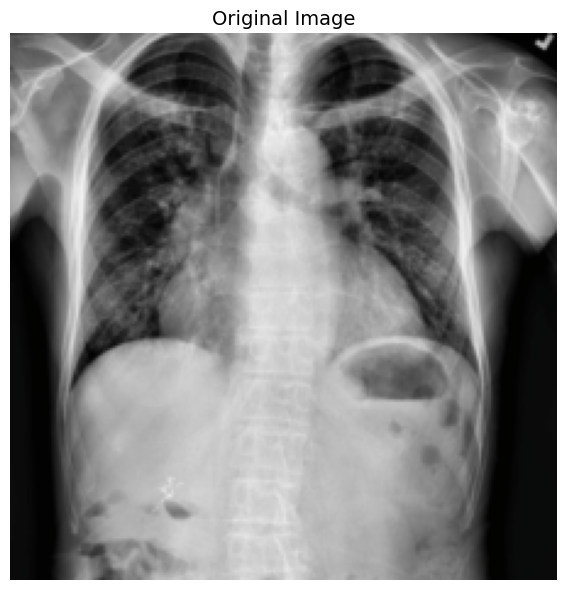


Generating GradCAM for Cardiomegaly (Ensemble prob: 0.574)


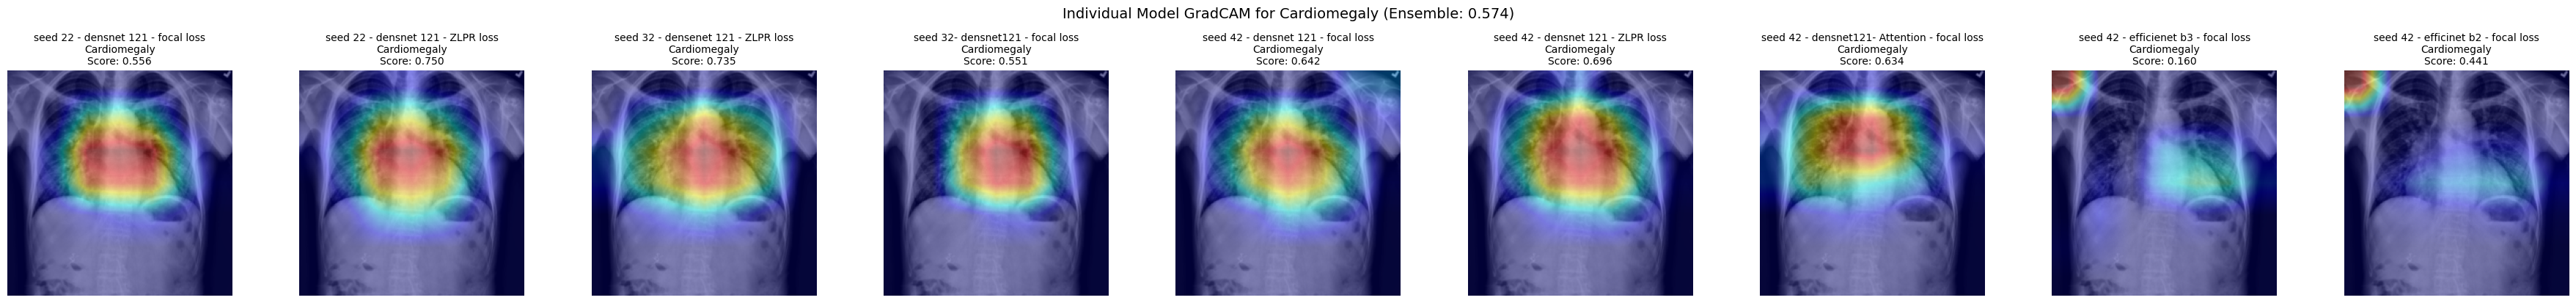

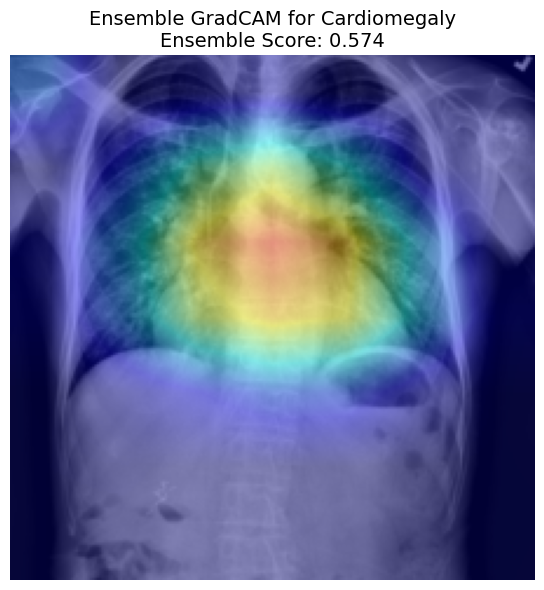

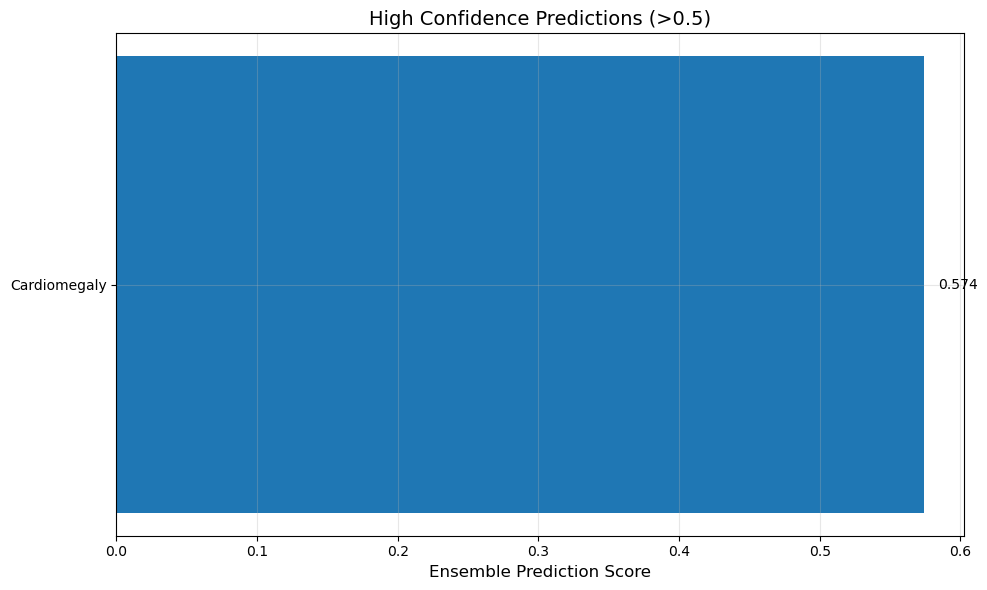

In [11]:
# Process Sample 1
print(f"=== SAMPLE 1 ===")
sample_1_path="00006113_002.png"
print(f"Path: {os.path.basename(sample_1_path)}")
print(f"True labels: {get_true_disease_labels(sample_1_labels)}")

# Get ensemble prediction for sample 1
with torch.no_grad():
    input_batch = sample_1_image.unsqueeze(0).to(CONFIG['device'])
    batch_predictions = []
    for model in models:
        output = model(input_batch)
        batch_predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    ensemble_pred_1 = np.mean(batch_predictions, axis=0)

# Show classes with probability > 0.5 (these will get GradCAM visualization)
high_conf_classes_1 = [(disease_list[j], ensemble_pred_1[j]) for j in range(len(disease_list)) if ensemble_pred_1[j] > 0.5]
if high_conf_classes_1:
    print("Diseases with ensemble prediction >0.5 (will show GradCAM):")
    for disease, prob in high_conf_classes_1:
        print(f"  - {disease}: {prob:.3f}")
else:
    print("No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)")

print(f"Highest ensemble prediction: {disease_list[np.argmax(ensemble_pred_1)]} (score: {np.max(ensemble_pred_1):.3f})")
print("=" * 50)

# Visualize Sample 1
individual_preds_1, ensemble_pred_viz_1 = visualize_high_confidence_gradcam(
    sample_1_image, sample_1_path, models, model_names, disease_list, CONFIG['device']
)

## Sample 2 Visualization

=== SAMPLE 2 ===
Path: 00026232_026.png
True labels: ['No Finding']
Diseases with ensemble prediction >0.5 (will show GradCAM):
  - Infiltration: 0.518
Highest ensemble prediction: Infiltration (score: 0.518)


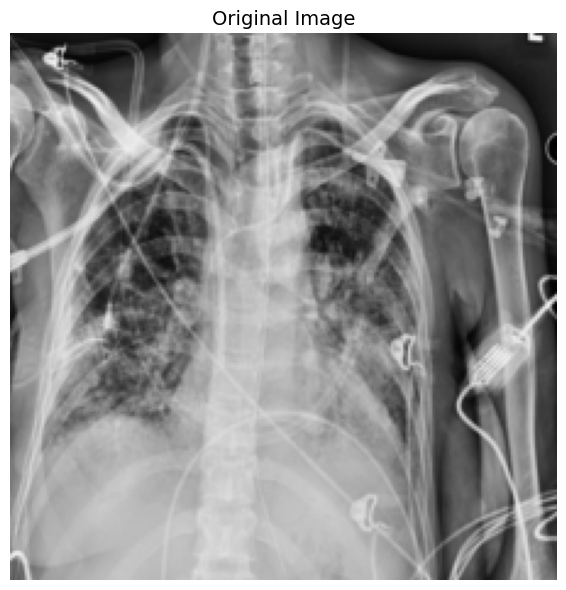


Generating GradCAM for Infiltration (Ensemble prob: 0.518)


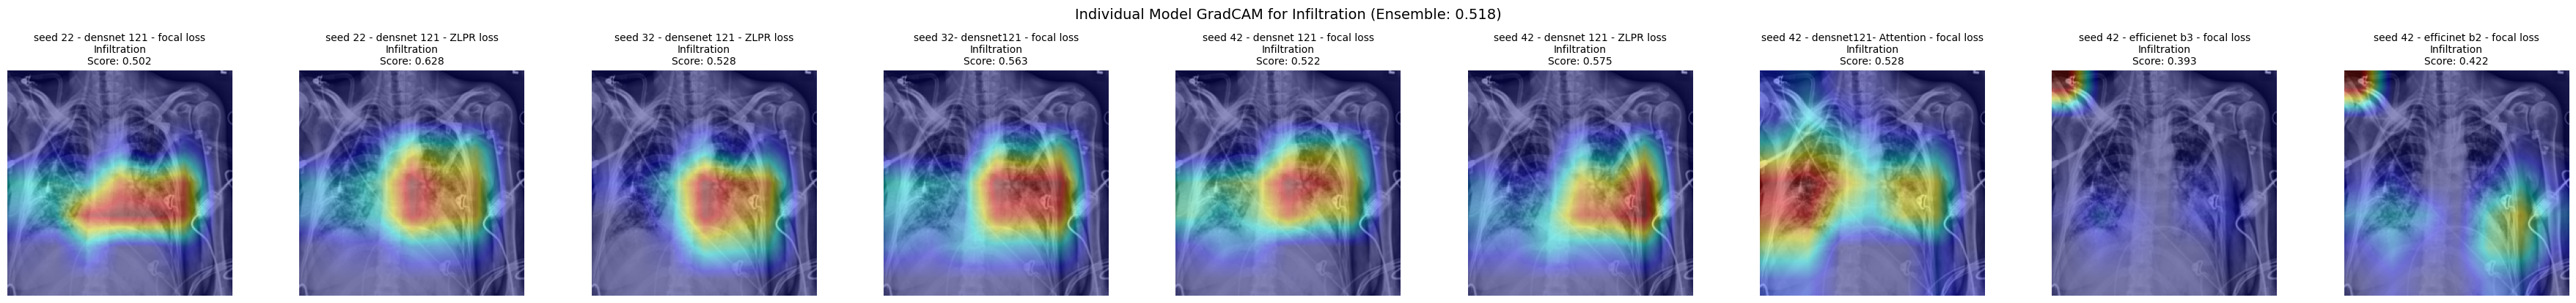

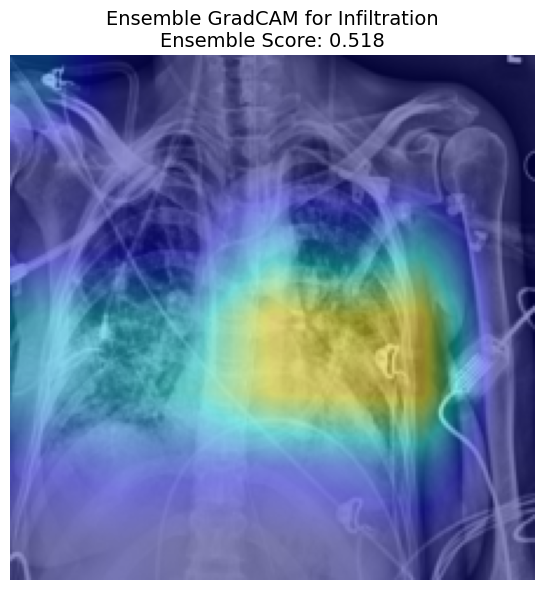

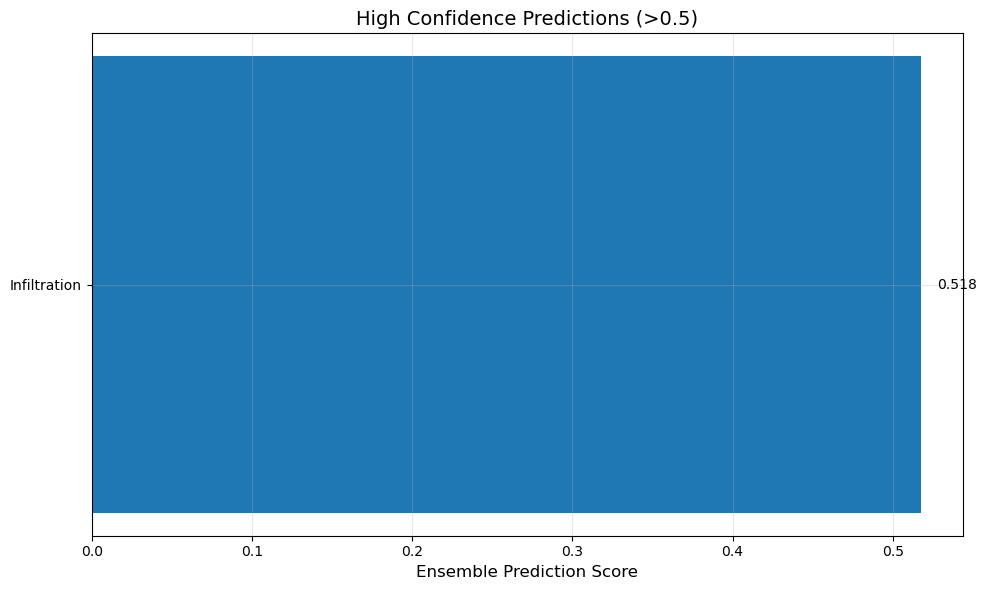

In [12]:
# Process Sample 2
print(f"=== SAMPLE 2 ===")
print(f"Path: {os.path.basename(sample_2_path)}")
print(f"True labels: {get_true_disease_labels(sample_2_labels)}")

# Get ensemble prediction for sample 2
with torch.no_grad():
    input_batch = sample_2_image.unsqueeze(0).to(CONFIG['device'])
    batch_predictions = []
    for model in models:
        output = model(input_batch)
        batch_predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    ensemble_pred_2 = np.mean(batch_predictions, axis=0)

# Show classes with probability > 0.5 (these will get GradCAM visualization)
high_conf_classes_2 = [(disease_list[j], ensemble_pred_2[j]) for j in range(len(disease_list)) if ensemble_pred_2[j] > 0.5]
if high_conf_classes_2:
    print("Diseases with ensemble prediction >0.5 (will show GradCAM):")
    for disease, prob in high_conf_classes_2:
        print(f"  - {disease}: {prob:.3f}")
else:
    print("No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)")

print(f"Highest ensemble prediction: {disease_list[np.argmax(ensemble_pred_2)]} (score: {np.max(ensemble_pred_2):.3f})")
print("=" * 50)

# Visualize Sample 2
individual_preds_2, ensemble_pred_viz_2 = visualize_high_confidence_gradcam(
    sample_2_image, sample_2_path, models, model_names, disease_list, CONFIG['device']
)

## Sample 3 Visualization

In [13]:
# Process Sample 3
print(f"=== SAMPLE 3 ===")
print(f"Path: {os.path.basename(sample_3_path)}")
print(f"True labels: {get_true_disease_labels(sample_3_labels)}")

# Get ensemble prediction for sample 3
with torch.no_grad():
    input_batch = sample_3_image.unsqueeze(0).to(CONFIG['device'])
    batch_predictions = []
    for model in models:
        output = model(input_batch)
        batch_predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    ensemble_pred_3 = np.mean(batch_predictions, axis=0)

# Show classes with probability > 0.5 (these will get GradCAM visualization)
high_conf_classes_3 = [(disease_list[j], ensemble_pred_3[j]) for j in range(len(disease_list)) if ensemble_pred_3[j] > 0.5]
if high_conf_classes_3:
    print("Diseases with ensemble prediction >0.5 (will show GradCAM):")
    for disease, prob in high_conf_classes_3:
        print(f"  - {disease}: {prob:.3f}")
else:
    print("No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)")

print(f"Highest ensemble prediction: {disease_list[np.argmax(ensemble_pred_3)]} (score: {np.max(ensemble_pred_3):.3f})")
print("=" * 50)

# Visualize Sample 3
individual_preds_3, ensemble_pred_viz_3 = visualize_high_confidence_gradcam(
    sample_3_image, sample_3_path, models, model_names, disease_list, CONFIG['device']
)

=== SAMPLE 3 ===
Path: 00001504_000.png
True labels: ['No Finding']
No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)
Highest ensemble prediction: Atelectasis (score: 0.368)
No diseases with ensemble prediction > 0.5 found for this image.
No diseases with ensemble prediction > 0.5 found for this image.


In [14]:
# Process Sample 3
print(f"=== SAMPLE 4 ===")
print(f"Path: {os.path.basename(sample_4_path)}")
print(f"True labels: {get_true_disease_labels(sample_4_labels)}")

# Get ensemble prediction for sample 4
with torch.no_grad():
    input_batch = sample_4_image.unsqueeze(0).to(CONFIG['device'])
    batch_predictions = []
    for model in models:
        output = model(input_batch)
        batch_predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    ensemble_pred_4 = np.mean(batch_predictions, axis=0)

# Show classes with probability > 0.5 (these will get GradCAM visualization)
high_conf_classes_4 = [(disease_list[j], ensemble_pred_4[j]) for j in range(len(disease_list)) if ensemble_pred_4[j] > 0.5]
if high_conf_classes_4:
    print("Diseases with ensemble prediction >0.5 (will show GradCAM):")
    for disease, prob in high_conf_classes_4:
        print(f"  - {disease}: {prob:.3f}")
else:
    print("No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)")

print(f"Highest ensemble prediction: {disease_list[np.argmax(ensemble_pred_4)]} (score: {np.max(ensemble_pred_4):.3f})")
print("=" * 50)

# Visualize Sample 4
individual_preds_4, ensemble_pred_viz_4 = visualize_high_confidence_gradcam(
    sample_4_image, sample_4_path, models, model_names, disease_list, CONFIG['device']
)

=== SAMPLE 4 ===
Path: 00017582_009.png
True labels: ['Atelectasis']
No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)
Highest ensemble prediction: Atelectasis (score: 0.477)
No diseases with ensemble prediction > 0.5 found for this image.
No diseases with ensemble prediction > 0.5 found for this image.


## Sample 5 Visualization

=== SAMPLE 5 ===
Path: 00004121_003.png
True labels: ['Mass']
Diseases with ensemble prediction >0.5 (will show GradCAM):
  - Mass: 0.532
Highest ensemble prediction: Mass (score: 0.532)


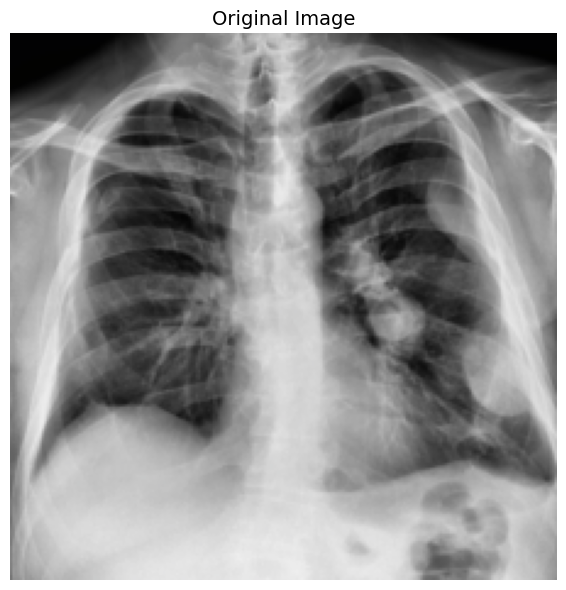


Generating GradCAM for Mass (Ensemble prob: 0.532)


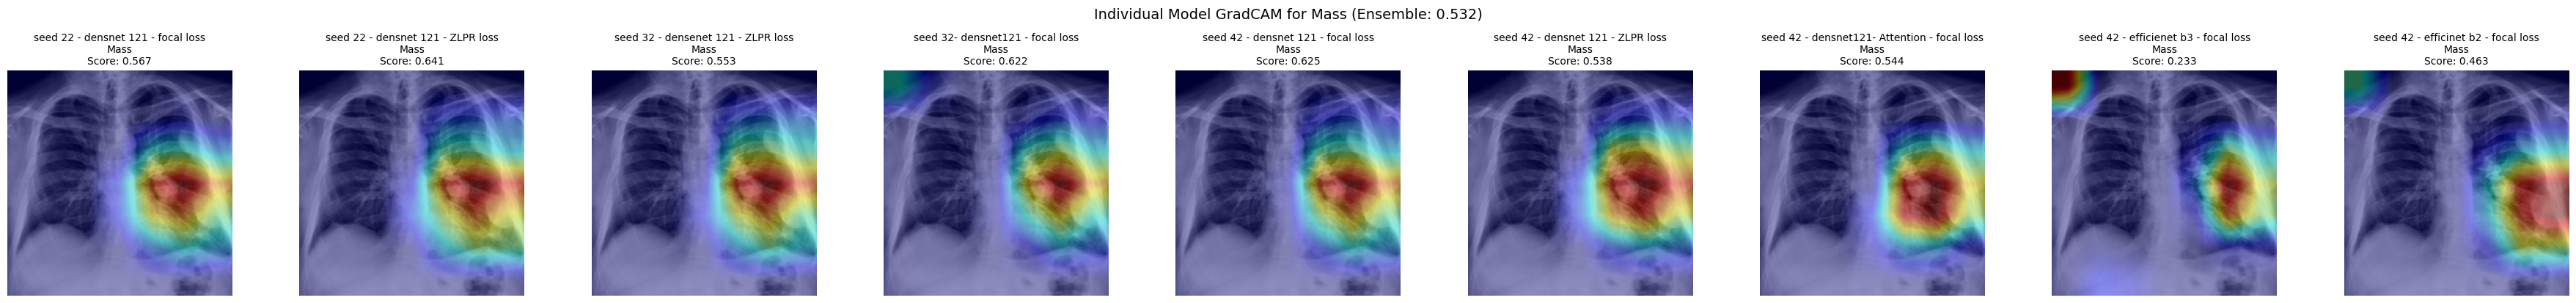

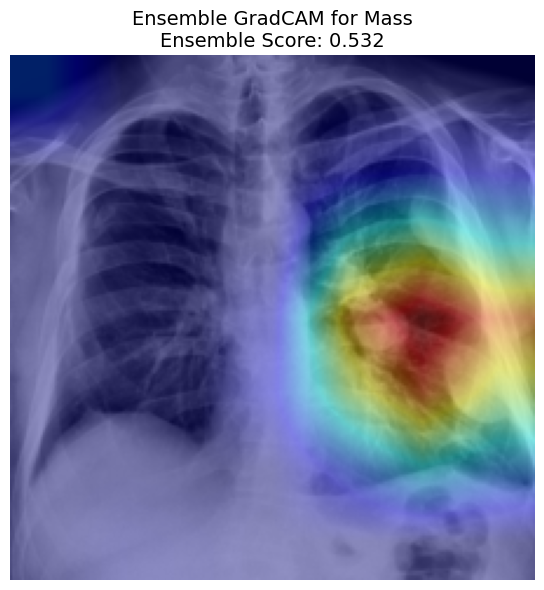

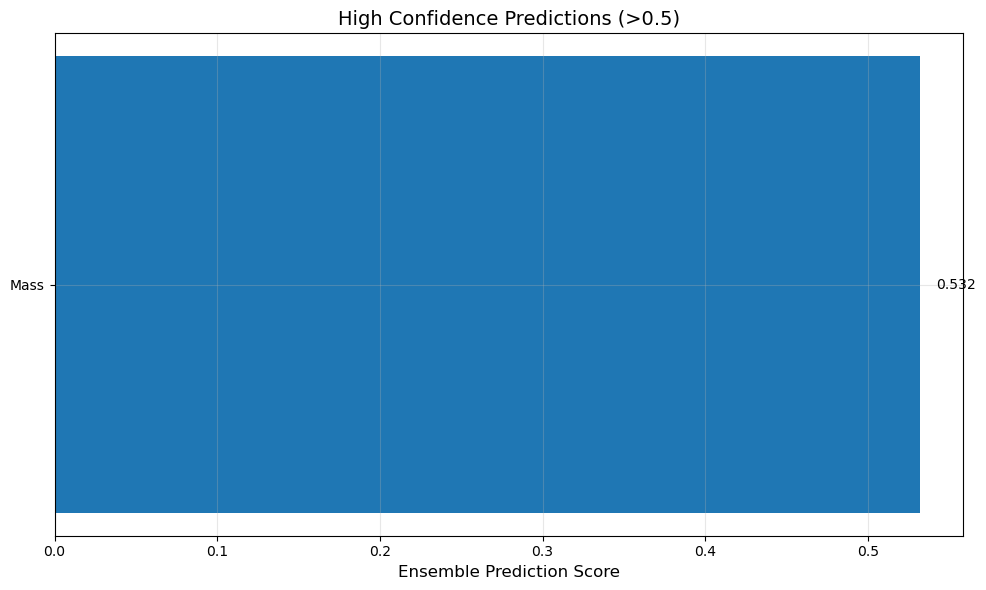

In [15]:
# Process Sample 5
print(f"=== SAMPLE 5 ===")
sample_5_path="00004121_003.png"
print(f"Path: {os.path.basename(sample_5_path)}")
print(f"True labels: {get_true_disease_labels(sample_5_labels)}")

# Get ensemble prediction for sample 5
with torch.no_grad():
    input_batch = sample_5_image.unsqueeze(0).to(CONFIG['device'])
    batch_predictions = []
    for model in models:
        output = model(input_batch)
        batch_predictions.append(torch.sigmoid(output).cpu().numpy()[0])
    ensemble_pred_5 = np.mean(batch_predictions, axis=0)

# Show classes with probability > 0.5 (these will get GradCAM visualization)
high_conf_classes_5 = [(disease_list[j], ensemble_pred_5[j]) for j in range(len(disease_list)) if ensemble_pred_5[j] > 0.5]
if high_conf_classes_5:
    print("Diseases with ensemble prediction >0.5 (will show GradCAM):")
    for disease, prob in high_conf_classes_5:
        print(f"  - {disease}: {prob:.3f}")
else:
    print("No diseases with ensemble prediction >0.5 (no GradCAM heatmaps will be shown)")

print(f"Highest ensemble prediction: {disease_list[np.argmax(ensemble_pred_5)]} (score: {np.max(ensemble_pred_5):.3f})")
print("=" * 50)

# Visualize Sample 5
individual_preds_5, ensemble_pred_viz_5 = visualize_high_confidence_gradcam(
    sample_5_image, sample_5_path, models, model_names, disease_list, CONFIG['device']
)